In [1]:
# install pyvips and its dependency
!dpkg -i --force-depends /kaggle/input/pyvips-offline/archives/*.deb >/dev/null 2>&1
!pip install --no-index --find-links /kaggle/input/pyvips-offline cffi==1.15.1 
!pip install --no-index --find-links /kaggle/input/pyvips-offline pycparser==2.21
!pip install --no-index --find-links /kaggle/input/pyvips-offline pyvips==2.2.1

Looking in links: /kaggle/input/pyvips-offline
Looking in links: /kaggle/input/pyvips-offline
Looking in links: /kaggle/input/pyvips-offline
Processing /kaggle/input/pyvips-offline/pyvips-2.2.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for pyvips: filename=pyvips-2.2.1-py2.py3-none-any.whl size=54177 sha256=2b84f2e771c2c11fdd5b59c20635adcff232a8c548aed5d960f9ce87046799c8
  Stored in directory: /root/.cache/pip/wheels/90/f6/9f/9e6c9bc8dbccbf6dc102bf4827898ee029f9b241f09a94caa4
Successfully built pyvips


In [2]:
import pyvips
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
print('libraries imported')

libraries imported


In [5]:
# Reading in the train and test data
df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
df.head

<bound method NDFrame.head of      image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]>

In [7]:
%%time
import os
import shutil
from pathlib import Path
import pyvips

# Creating train step directory
train_dir = '/kaggle/input/UBC-OCEAN/train_images'
output_dir = '/kaggle/working/train_data'

Path(output_dir).mkdir(parents=True, exist_ok=True)

# Set the desired size for compressed images
target_width = 224
target_height = 224

for image_id, label, _, _, _ in df.values:
    # Create subdirectory with class name
    class_dir = Path(output_dir) / str(label)
    class_dir.mkdir(parents=True, exist_ok=True)

    src_path = Path(train_dir) / f'{image_id}.png'
    dst_path = class_dir / f'{image_id}.png'

    try:
        # Open the image with pyvips
        img = pyvips.Image.new_from_file(str(src_path), access='sequential')

        img = img.resize(target_width / img.width)
        img = img.resize(target_height / img.height)
        img.write_to_file(str(dst_path), Q=85)  # You can adjust the Q parameter

        print(f'Successfully compressed and copied {image_id}.png to {class_dir}')
    except pyvips.Error as e:
        print(f'Unable to process file: {e}')
    except Exception as e:
        print(f'Error: {e}')


Successfully compressed and copied 4.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 66.png to /kaggle/working/train_data/LGSC
Successfully compressed and copied 91.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 281.png to /kaggle/working/train_data/LGSC
Successfully compressed and copied 286.png to /kaggle/working/train_data/EC
Successfully compressed and copied 431.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 706.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 970.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 1020.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 1080.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 1101.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 1252.png to /kaggle/working/train_data/HGSC
Successfully compressed and copied 1289.png to /kaggle/working/tra

In [32]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten,BatchNormalization, Input, Layer, Resizing, Rescaling, Dropout, RandomRotation, RandomContrast,RandomFlip
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from sklearn.metrics import confusion_matrix

## Splitting Data into training and validation sets

In [11]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [12]:
import splitfolders
path = "/kaggle/working/train_data"
splitfolders.ratio(path,seed=1337, output="UBC-Splitted", ratio=(0.8, 0.2))

Copying files: 538 files [00:01, 499.54 files/s]


In [17]:
train_directory = '/kaggle/working/UBC-Splitted/train'
val_directory = '/kaggle/working/UBC-Splitted/val'
CLASS_NAMES=['EC','LGSC','MC','HGSC','CC']

CONFIGURATION= {
    'BATCH_SIZE':32,
    'IM_SIZE':224,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS' : 20,
    'DROPOUT_RATE' : 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS' : 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1' : 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 5
}

In [18]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 428 files belonging to 5 classes.


In [19]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 110 files belonging to 5 classes.


In [20]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




## Data Visualization

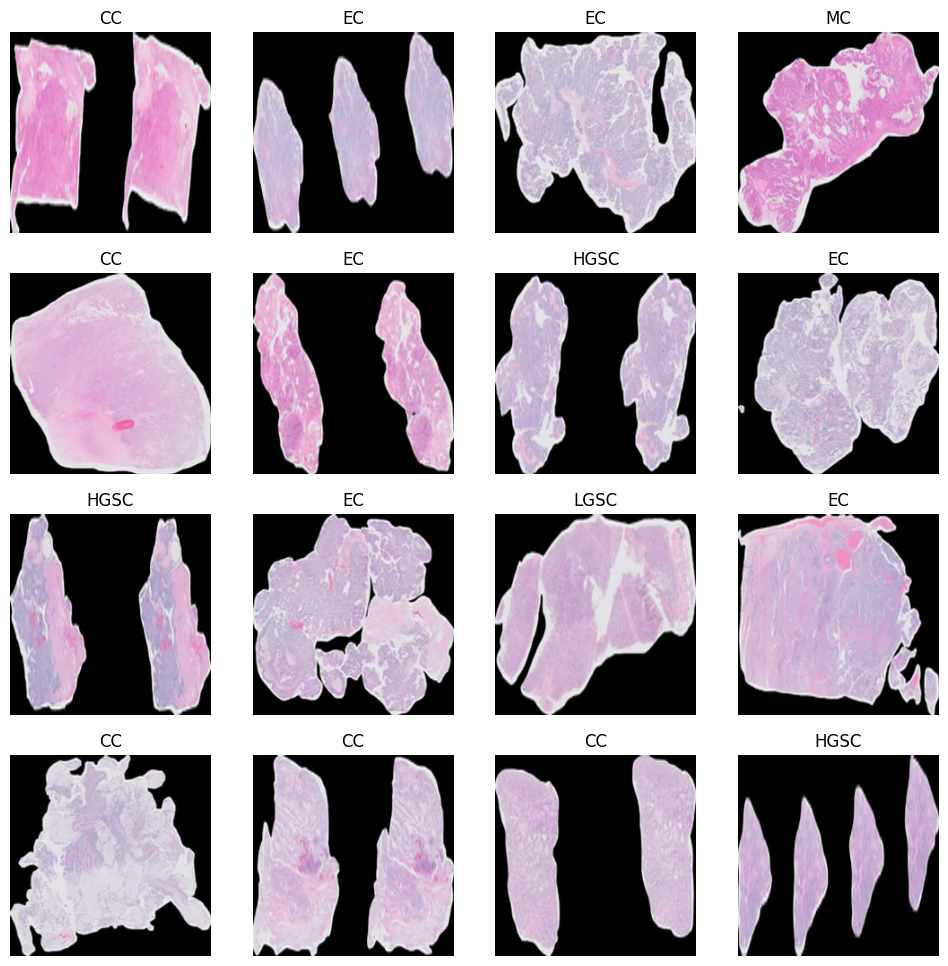

In [21]:
plt.figure(figsize=(12,12))

for image, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')

## Data Augmentation

In [22]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025,0.25),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1)
])

In [23]:
def augment_layer (image, label):
  return augment_layers(image, training = True), label

## Data Preparation

In [24]:
training_dataset =(
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [25]:
validation_dataset =(
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [26]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255.),
])

## Modelling

In [27]:
lenet_model = tf.keras.Sequential([

    InputLayer(input_shape=(None, None,3)),
    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'],
           activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'],
           activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation='relu',kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE']) ),
    BatchNormalization(),

    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')
 ])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 6)      

## Training

In [28]:
loss_function = CategoricalCrossentropy(from_logits = False)

In [31]:
metrics = [CategoricalAccuracy(name = 'accuracy'),TopKCategoricalAccuracy(k=2, name = 'top_k_accuracy')]

In [33]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [34]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
14/14 [==============================] - 11s 563ms/step - loss: 1.8053 - accuracy: 0.2804 - top_k_accuracy: 0.4393 - val_loss: 5.3503 - val_accuracy: 0.2273 - val_top_k_accuracy: 0.3182
Epoch 2/20
14/14 [==============================] - 8s 529ms/step - loss: 1.6693 - accuracy: 0.3014 - top_k_accuracy: 0.4907 - val_loss: 2.8473 - val_accuracy: 0.2364 - val_top_k_accuracy: 0.3455
Epoch 3/20
14/14 [==============================] - 8s 544ms/step - loss: 1.6245 - accuracy: 0.3341 - top_k_accuracy: 0.5023 - val_loss: 2.2264 - val_accuracy: 0.2909 - val_top_k_accuracy: 0.3455
Epoch 4/20
14/14 [==============================] - 8s 523ms/step - loss: 1.5605 - accuracy: 0.3692 - top_k_accuracy: 0.5724 - val_loss: 1.8140 - val_accuracy: 0.2545 - val_top_k_accuracy: 0.3545
Epoch 5/20
14/14 [==============================] - 8s 531ms/step - loss: 1.5439 - accuracy: 0.3645 - top_k_accuracy: 0.5584 - val_loss: 1.7064 - val_accuracy: 0.2364 - val_top_k_accuracy: 0.4182
Epoch 6/20
14/14 [=